In [2]:
import numpy as np
import pickle
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm
from torchvision import transforms
from torchvision.datasets import Imagenette
from torch.utils.data.sampler import SubsetRandomSampler
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.transforms import v2
import torchvision
import math

BATCH_SIZE = 64

CLASS_NUM = 10

In [3]:
!rm -rf /kaggle/working/*

# Data

In [4]:
class CustomTensorDataset(Dataset):
    def __init__(self, X, y, transform):
        self.X = X
        self.y = y
        self.transform = transform
    def __len__(self):
        return len(self.X)



    def __getitem__(self, idx):
        image, label = self.X[idx], self.y[idx]
        image = self.transform(image)
        return image, label

In [5]:
train_transform = transforms.Compose([
    v2.RandAugment(5,14),
    v2.RandomCrop(224, padding=16),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])



test_transform = transforms.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])



train_dataset  = Imagenette('./data/',split='train',transform=transforms.Compose([v2.Resize((224, 224)), v2.ToImage()]),download=True)
test_dataset   = Imagenette('./data/',split='val',transform=transforms.Compose([v2.Resize((224, 224)), v2.ToImage()]),download=False)


print('loading data on ram')
train_data   = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))])
train_labels = torch.tensor([train_dataset[i][1] for i in range(len(train_dataset))])
test_data    = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])
test_labels  = torch.tensor([test_dataset[i][1] for i in range(len(test_dataset))])
indices = torch.randperm(len(train_data))


indices_train = indices[:int(0.9 * len(train_data))]
indices_valid = indices[int(0.9 * len(train_data)):]



valid_data   = train_data[indices_valid]
train_data   = train_data[indices_train]


valid_labels = train_labels[indices_valid]
train_labels = train_labels[indices_train]


train_dataset = CustomTensorDataset(train_data, train_labels, transform=train_transform)
valid_dataset = CustomTensorDataset(valid_data, valid_labels, transform=test_transform)
test_dataset  = CustomTensorDataset(test_data, test_labels, transform=test_transform)


batch_size = 64


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, num_workers=4, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True, num_workers=4, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 1557161267/1557161267 [00:45<00:00, 34196921.14it/s]


Extracting ./data/imagenette2.tgz to ./data/
loading data on ram


# Network

In [6]:
class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature







    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """

        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))



        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')

        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)
        batch_size = features.shape[0]

        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')



        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)



        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)

        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)



        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))



        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)

        # for numerical stability

        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()



        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases

        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask
        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))



        # compute mean of log-likelihood over positive

        # modified to handle edge cases when there is no positive pair

        # for an anchor point.

        # Edge case e.g.:-

        # features of shape: [4,1,...]

        # labels:            [0,1,1,2]

        # loss before mean:  [nan, ..., ..., nan]

        mask_pos_pairs = mask.sum(1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask_pos_pairs

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()
        return loss

In [7]:
from torchvision.models import resnet101, ResNet101_Weights


encoder = resnet101(ResNet101_Weights.IMAGENET1K_V2)
encoder.fc = nn.Identity()


class NormalizeLayer(nn.Module):
    def __init__(self):
        super(NormalizeLayer, self).__init__()

    def forward(self, x):
        # Normalize the input tensor `x` using the specified parameters
        return F.normalize(x)


projection_head = nn.Sequential(
      nn.Flatten(),
      nn.Linear(2048,2048),
      nn.ReLU(),
      nn.Linear(2048,128),
      NormalizeLayer()
)



# model = torch.nn.DataParallel(model)
# projection_head = torch.nn.DataParallel(projection_head)



encoder.to('cuda')
projection_head.to('cuda')

print(encoder)
print(projection_head)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:00<00:00, 227MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Training

In [8]:
import torch.optim as optim

criterion = SupConLoss()
learning_rate = 0.0006
lr_decay_rate = 0.1
n_epochs = 60


optimizer = optim.AdamW(list(encoder.parameters()) + list(projection_head.parameters()), lr=learning_rate)



def adjust_learning_rate(optimizer, epoch):
    lr = np.copy(learning_rate)
    eta_min = lr * (lr_decay_rate ** 3)
    lr = eta_min + (lr - eta_min) * (
            1 + math.cos(math.pi * epoch / n_epochs)) / 2



    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
valid_loss_min = np.Inf 
train_losses_dict = {}
valid_losses_dict = {}


for epoch in range(1, n_epochs+1):
    adjust_learning_rate(optimizer, epoch)
    train_loss = 0.0
    valid_loss = 0.0

    ###################

    # train the model #

    ###################


    encoder.train()
    projection_head.train()
    for batch in tqdm(train_loader):
        x, y = batch[0].cuda(), torch.flatten(batch[1].cuda())
        optimizer.zero_grad()
        output = encoder(x)
        output = projection_head(output)
        output = torch.cat([output.unsqueeze(1), output.unsqueeze(1)], dim=1)
        loss   = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*x.size(0)
        




    ######################    

    # validate the model #

    ######################

    encoder.eval()
    projection_head.eval()
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            x, y = batch[0].cuda(), torch.flatten(batch[1].cuda())
            output = encoder(x)
            output = projection_head(output)
            output = torch.cat([output.unsqueeze(1), output.unsqueeze(1)], dim=1)
            loss   = criterion(output, y)       
            valid_loss += loss.item()*x.size(0)
            




    # calculate average losses

    train_loss = train_loss/len(train_labels)
    valid_loss = valid_loss/len(valid_labels)
    train_losses_dict[epoch] = train_loss
    valid_losses_dict[epoch] = valid_loss

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(

        epoch, train_loss, valid_loss))

    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(encoder.state_dict(), 'encoder_teacher.pt')
        torch.save(projection_head.state_dict(), 'projection_head_teacher.pt')
        valid_loss_min = np.copy(valid_loss)


os.makedirs('/kaggle/working/Pickles', exist_ok=True)


train_losses_path = '/kaggle/working/Pickles/train_losses_encoder_resnet101.pkl'
valid_losses_path = '/kaggle/working/Pickles/valid_losses_encoder_resnet101.pkl'


if not os.path.exists(train_losses_path):
    fd = os.open('/kaggle/working/Pickles/train_losses_encoder_resnet101.pkl', os.O_CREAT)
    os.close(fd)
    with open(train_losses_path, 'wb') as f:
        pickle.dump(train_losses_dict, f)
    print("Training losses saved!")
else:
    with open(train_losses_path, 'wb') as f:
        pickle.dump(train_losses_dict, f)
    print("Training losses saved!")


if not os.path.exists(valid_losses_path):
    fd = os.open('/kaggle/working/Pickles/valid_losses_encoder_resnet101.pkl', os.O_CREAT)
    os.close(fd)
    with open(valid_losses_path, 'wb') as f:
        pickle.dump(valid_losses_dict, f)
    print("Validation losses saved!")
else:
    with open(valid_losses_path, 'wb') as f:
        pickle.dump(valid_losses_dict, f)
    print("Validation losses saved!")


100%|██████████| 15/15 [00:03<00:00,  4.96it/s]


Epoch: 1 	Training Loss: 3.267910 	Validation Loss: 3.012355
Validation loss decreased (inf --> 3.012355).  Saving model ...


100%|██████████| 15/15 [00:03<00:00,  4.95it/s]


Epoch: 2 	Training Loss: 3.088496 	Validation Loss: 2.864526
Validation loss decreased (3.012355 --> 2.864526).  Saving model ...


100%|██████████| 15/15 [00:02<00:00,  5.24it/s]


Epoch: 3 	Training Loss: 3.021752 	Validation Loss: 2.967794


100%|██████████| 15/15 [00:02<00:00,  5.31it/s]


Epoch: 4 	Training Loss: 2.951213 	Validation Loss: 2.814584
Validation loss decreased (2.864526 --> 2.814584).  Saving model ...


100%|██████████| 15/15 [00:02<00:00,  5.25it/s]


Epoch: 5 	Training Loss: 2.971568 	Validation Loss: 2.880826


100%|██████████| 15/15 [00:02<00:00,  5.14it/s]


Epoch: 6 	Training Loss: 2.893156 	Validation Loss: 2.856511


100%|██████████| 15/15 [00:02<00:00,  5.02it/s]


Epoch: 7 	Training Loss: 2.879690 	Validation Loss: 2.860417


100%|██████████| 15/15 [00:02<00:00,  5.10it/s]


Epoch: 8 	Training Loss: 2.849378 	Validation Loss: 2.859833


100%|██████████| 15/15 [00:02<00:00,  5.24it/s]


Epoch: 9 	Training Loss: 2.834256 	Validation Loss: 2.901534


100%|██████████| 15/15 [00:02<00:00,  5.30it/s]


Epoch: 10 	Training Loss: 2.821693 	Validation Loss: 2.889873


100%|██████████| 15/15 [00:02<00:00,  5.23it/s]


Epoch: 11 	Training Loss: 2.841598 	Validation Loss: 2.888336


100%|██████████| 15/15 [00:02<00:00,  5.14it/s]


Epoch: 12 	Training Loss: 2.798977 	Validation Loss: 2.803772
Validation loss decreased (2.814584 --> 2.803772).  Saving model ...


100%|██████████| 15/15 [00:02<00:00,  5.31it/s]


Epoch: 13 	Training Loss: 2.791206 	Validation Loss: 2.858556


100%|██████████| 15/15 [00:02<00:00,  5.12it/s]


Epoch: 14 	Training Loss: 2.767883 	Validation Loss: 2.836565


100%|██████████| 15/15 [00:02<00:00,  5.22it/s]


Epoch: 15 	Training Loss: 2.781098 	Validation Loss: 2.782393
Validation loss decreased (2.803772 --> 2.782393).  Saving model ...


100%|██████████| 15/15 [00:02<00:00,  5.17it/s]


Epoch: 16 	Training Loss: 2.764393 	Validation Loss: 2.780850
Validation loss decreased (2.782393 --> 2.780850).  Saving model ...


100%|██████████| 15/15 [00:02<00:00,  5.13it/s]


Epoch: 17 	Training Loss: 2.728139 	Validation Loss: 2.848358


100%|██████████| 15/15 [00:02<00:00,  5.09it/s]


Epoch: 18 	Training Loss: 2.760279 	Validation Loss: 2.760867
Validation loss decreased (2.780850 --> 2.760867).  Saving model ...


100%|██████████| 15/15 [00:02<00:00,  5.18it/s]


Epoch: 19 	Training Loss: 2.711385 	Validation Loss: 2.821588


100%|██████████| 15/15 [00:02<00:00,  5.09it/s]


Epoch: 20 	Training Loss: 2.713365 	Validation Loss: 2.825452


100%|██████████| 15/15 [00:02<00:00,  5.19it/s]


Epoch: 21 	Training Loss: 2.678464 	Validation Loss: 2.782075


100%|██████████| 15/15 [00:02<00:00,  5.10it/s]


Epoch: 22 	Training Loss: 2.695470 	Validation Loss: 2.824590


100%|██████████| 15/15 [00:02<00:00,  5.31it/s]


Epoch: 23 	Training Loss: 2.664848 	Validation Loss: 2.771481


100%|██████████| 15/15 [00:02<00:00,  5.17it/s]


Epoch: 24 	Training Loss: 2.680612 	Validation Loss: 2.819409


100%|██████████| 15/15 [00:02<00:00,  5.31it/s]


Epoch: 25 	Training Loss: 2.685315 	Validation Loss: 2.787280


100%|██████████| 15/15 [00:02<00:00,  5.15it/s]


Epoch: 26 	Training Loss: 2.647186 	Validation Loss: 2.833445


100%|██████████| 15/15 [00:02<00:00,  5.15it/s]


Epoch: 27 	Training Loss: 2.640866 	Validation Loss: 2.765837


100%|██████████| 15/15 [00:02<00:00,  5.09it/s]


Epoch: 28 	Training Loss: 2.637676 	Validation Loss: 2.758043
Validation loss decreased (2.760867 --> 2.758043).  Saving model ...


100%|██████████| 15/15 [00:02<00:00,  5.23it/s]


Epoch: 29 	Training Loss: 2.644029 	Validation Loss: 2.820290


100%|██████████| 15/15 [00:02<00:00,  5.19it/s]


Epoch: 30 	Training Loss: 2.629024 	Validation Loss: 2.789765


100%|██████████| 15/15 [00:02<00:00,  5.18it/s]


Epoch: 31 	Training Loss: 2.627921 	Validation Loss: 2.773919


100%|██████████| 15/15 [00:02<00:00,  5.15it/s]


Epoch: 32 	Training Loss: 2.623683 	Validation Loss: 2.753511
Validation loss decreased (2.758043 --> 2.753511).  Saving model ...


100%|██████████| 15/15 [00:02<00:00,  5.13it/s]


Epoch: 33 	Training Loss: 2.613468 	Validation Loss: 2.780206


100%|██████████| 15/15 [00:02<00:00,  5.22it/s]


Epoch: 34 	Training Loss: 2.613737 	Validation Loss: 2.747576
Validation loss decreased (2.753511 --> 2.747576).  Saving model ...


100%|██████████| 15/15 [00:02<00:00,  5.21it/s]


Epoch: 35 	Training Loss: 2.609088 	Validation Loss: 2.741114
Validation loss decreased (2.747576 --> 2.741114).  Saving model ...


100%|██████████| 15/15 [00:02<00:00,  5.08it/s]


Epoch: 36 	Training Loss: 2.606623 	Validation Loss: 2.742784


100%|██████████| 15/15 [00:03<00:00,  4.96it/s]


Epoch: 37 	Training Loss: 2.595458 	Validation Loss: 2.768808


100%|██████████| 15/15 [00:02<00:00,  5.22it/s]


Epoch: 38 	Training Loss: 2.588996 	Validation Loss: 2.734307
Validation loss decreased (2.741114 --> 2.734307).  Saving model ...


100%|██████████| 15/15 [00:02<00:00,  5.14it/s]


Epoch: 39 	Training Loss: 2.595269 	Validation Loss: 2.757677


100%|██████████| 15/15 [00:02<00:00,  5.15it/s]


Epoch: 40 	Training Loss: 2.586279 	Validation Loss: 2.763258


100%|██████████| 15/15 [00:02<00:00,  5.13it/s]


Epoch: 41 	Training Loss: 2.580267 	Validation Loss: 2.734260
Validation loss decreased (2.734307 --> 2.734260).  Saving model ...


100%|██████████| 15/15 [00:02<00:00,  5.24it/s]


Epoch: 42 	Training Loss: 2.567489 	Validation Loss: 2.736051


100%|██████████| 15/15 [00:02<00:00,  5.11it/s]


Epoch: 43 	Training Loss: 2.580960 	Validation Loss: 2.726204
Validation loss decreased (2.734260 --> 2.726204).  Saving model ...


100%|██████████| 15/15 [00:02<00:00,  5.16it/s]


Epoch: 44 	Training Loss: 2.583761 	Validation Loss: 2.735349


100%|██████████| 15/15 [00:02<00:00,  5.08it/s]


Epoch: 45 	Training Loss: 2.575579 	Validation Loss: 2.745881


100%|██████████| 15/15 [00:02<00:00,  5.09it/s]


Epoch: 46 	Training Loss: 2.568697 	Validation Loss: 2.756509


100%|██████████| 15/15 [00:02<00:00,  5.23it/s]


Epoch: 47 	Training Loss: 2.576050 	Validation Loss: 2.722384
Validation loss decreased (2.726204 --> 2.722384).  Saving model ...


100%|██████████| 15/15 [00:02<00:00,  5.12it/s]


Epoch: 48 	Training Loss: 2.565821 	Validation Loss: 2.740325


100%|██████████| 15/15 [00:02<00:00,  5.29it/s]


Epoch: 49 	Training Loss: 2.560244 	Validation Loss: 2.733442


100%|██████████| 15/15 [00:02<00:00,  5.22it/s]


Epoch: 50 	Training Loss: 2.569145 	Validation Loss: 2.722578


100%|██████████| 15/15 [00:02<00:00,  5.22it/s]


Epoch: 51 	Training Loss: 2.558624 	Validation Loss: 2.739356


100%|██████████| 15/15 [00:02<00:00,  5.26it/s]


Epoch: 52 	Training Loss: 2.564567 	Validation Loss: 2.724406


100%|██████████| 15/15 [00:02<00:00,  5.17it/s]


Epoch: 53 	Training Loss: 2.565847 	Validation Loss: 2.732800


100%|██████████| 15/15 [00:02<00:00,  5.12it/s]


Epoch: 54 	Training Loss: 2.564089 	Validation Loss: 2.728773


100%|██████████| 15/15 [00:02<00:00,  5.11it/s]


Epoch: 55 	Training Loss: 2.567821 	Validation Loss: 2.740953


100%|██████████| 15/15 [00:02<00:00,  5.15it/s]


Epoch: 56 	Training Loss: 2.558717 	Validation Loss: 2.745344


100%|██████████| 15/15 [00:02<00:00,  5.16it/s]


Epoch: 57 	Training Loss: 2.560453 	Validation Loss: 2.725319


100%|██████████| 15/15 [00:02<00:00,  5.23it/s]


Epoch: 58 	Training Loss: 2.561134 	Validation Loss: 2.703355
Validation loss decreased (2.722384 --> 2.703355).  Saving model ...


100%|██████████| 15/15 [00:02<00:00,  5.07it/s]


Epoch: 59 	Training Loss: 2.556987 	Validation Loss: 2.727880


100%|██████████| 15/15 [00:02<00:00,  5.14it/s]

Epoch: 60 	Training Loss: 2.564924 	Validation Loss: 2.737035
Training losses saved!
Validation losses saved!


In [10]:
encoder.load_state_dict(torch.load('/kaggle/working/encoder_teacher.pt'))
classifier = nn.Linear(2048, CLASS_NUM).to('cuda')



# classifier = nn.Sequential(
#       nn.Flatten(),
#       nn.Linear(2048,2048),
#       nn.ReLU(),
#       nn.Linear(2048,CLASS_NUM),
# ).to('cuda')


for name, param in encoder.named_parameters():
    param.requires_grad = False


encoder.eval()      

/tmp/ipykernel_30/1144737555.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load('/kaggle/working/encoder_teacher.pt'))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(classifier.parameters(), lr=0.0005)

In [12]:
n_epochs = 40

valid_loss_min = np.Inf
train_losses_dict = {}
valid_losses_dict = {}


for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0


    ###################
    
    # train the model #

    ###################
    classifier.train()
    for batch in tqdm(train_loader):
        x, y = batch[0].cuda(), batch[1].cuda()
        optimizer.zero_grad()
        with torch.no_grad():
            output = encoder(x)
        output = classifier(output.detach())
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*x.size(0)



    ######################    

    # validate the model #

    ######################

    classifier.eval()
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            x, y = batch[0].cuda(), batch[1].cuda()
            output = classifier(encoder(x))
            loss = criterion(output, y)
            valid_loss += loss.item()*x.size(0)


    train_loss = train_loss/len(train_labels)
    valid_loss = valid_loss/len(valid_labels)
    train_losses_dict[epoch] = train_loss
    valid_losses_dict[epoch] = valid_loss

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))


    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(classifier.state_dict(), 'classifier.pt')
        valid_loss_min = valid_loss


os.makedirs('/kaggle/working/Pickles', exist_ok=True)


train_losses_path = '/kaggle/working/Pickles/train_losses_projection_head.pkl'
valid_losses_path = '/kaggle/working/Pickles/valid_losses_projection_head.pkl'


if not os.path.exists(train_losses_path):
    fd = os.open('/kaggle/working/Pickles/train_losses_projection_head.pkl', os.O_CREAT)
    os.close(fd)
    with open(train_losses_path, 'wb') as f:
        pickle.dump(train_losses_dict, f)
    print("Training losses saved!")
else:
    with open(train_losses_path, 'wb') as f:
        pickle.dump(train_losses_dict, f)
    print("Training losses saved!")


if not os.path.exists(valid_losses_path):
    fd = os.open('/kaggle/working/Pickles/valid_losses_projection_head.pkl', os.O_CREAT)
    os.close(fd)
    with open(valid_losses_path, 'wb') as f:
        pickle.dump(valid_losses_dict, f)
    print("Validation losses saved!")
else:
    with open(valid_losses_path, 'wb') as f:
        pickle.dump(valid_losses_dict, f)
    print("Validation losses saved!")

100%|██████████| 15/15 [00:02<00:00,  5.29it/s]


Epoch: 1 	Training Loss: 0.665571 	Validation Loss: 0.168436
Validation loss decreased (inf --> 0.168436).  Saving model ...


100%|██████████| 15/15 [00:02<00:00,  5.22it/s]


Epoch: 2 	Training Loss: 0.148098 	Validation Loss: 0.113822
Validation loss decreased (0.168436 --> 0.113822).  Saving model ...


100%|██████████| 15/15 [00:02<00:00,  5.11it/s]


Epoch: 3 	Training Loss: 0.092516 	Validation Loss: 0.098061
Validation loss decreased (0.113822 --> 0.098061).  Saving model ...


100%|██████████| 15/15 [00:02<00:00,  5.31it/s]


Epoch: 4 	Training Loss: 0.066510 	Validation Loss: 0.090129
Validation loss decreased (0.098061 --> 0.090129).  Saving model ...


100%|██████████| 15/15 [00:02<00:00,  5.27it/s]


Epoch: 5 	Training Loss: 0.053237 	Validation Loss: 0.085958
Validation loss decreased (0.090129 --> 0.085958).  Saving model ...


100%|██████████| 15/15 [00:02<00:00,  5.24it/s]


Epoch: 6 	Training Loss: 0.043001 	Validation Loss: 0.083318
Validation loss decreased (0.085958 --> 0.083318).  Saving model ...


100%|██████████| 15/15 [00:02<00:00,  5.16it/s]


Epoch: 7 	Training Loss: 0.038191 	Validation Loss: 0.081865
Validation loss decreased (0.083318 --> 0.081865).  Saving model ...


100%|██████████| 15/15 [00:02<00:00,  5.22it/s]


Epoch: 8 	Training Loss: 0.036891 	Validation Loss: 0.080762
Validation loss decreased (0.081865 --> 0.080762).  Saving model ...


100%|██████████| 15/15 [00:02<00:00,  5.14it/s]


Epoch: 9 	Training Loss: 0.030696 	Validation Loss: 0.080842


100%|██████████| 15/15 [00:02<00:00,  5.15it/s]


Epoch: 10 	Training Loss: 0.025411 	Validation Loss: 0.080784


100%|██████████| 15/15 [00:02<00:00,  5.35it/s]


Epoch: 11 	Training Loss: 0.026634 	Validation Loss: 0.080519
Validation loss decreased (0.080762 --> 0.080519).  Saving model ...


100%|██████████| 15/15 [00:02<00:00,  5.30it/s]


Epoch: 12 	Training Loss: 0.022967 	Validation Loss: 0.080436
Validation loss decreased (0.080519 --> 0.080436).  Saving model ...


100%|██████████| 15/15 [00:02<00:00,  5.16it/s]


Epoch: 13 	Training Loss: 0.021365 	Validation Loss: 0.080805


100%|██████████| 15/15 [00:02<00:00,  5.16it/s]


Epoch: 14 	Training Loss: 0.022352 	Validation Loss: 0.081453


100%|██████████| 15/15 [00:02<00:00,  5.23it/s]


Epoch: 15 	Training Loss: 0.017343 	Validation Loss: 0.081870


100%|██████████| 15/15 [00:02<00:00,  5.34it/s]


Epoch: 16 	Training Loss: 0.018132 	Validation Loss: 0.081675


100%|██████████| 15/15 [00:02<00:00,  5.35it/s]


Epoch: 17 	Training Loss: 0.018604 	Validation Loss: 0.081902


100%|██████████| 15/15 [00:02<00:00,  5.19it/s]


Epoch: 18 	Training Loss: 0.015642 	Validation Loss: 0.082734


100%|██████████| 15/15 [00:02<00:00,  5.33it/s]


Epoch: 19 	Training Loss: 0.014658 	Validation Loss: 0.084266


100%|██████████| 15/15 [00:02<00:00,  5.19it/s]


Epoch: 20 	Training Loss: 0.016566 	Validation Loss: 0.084021


100%|██████████| 15/15 [00:02<00:00,  5.20it/s]


Epoch: 21 	Training Loss: 0.016383 	Validation Loss: 0.083484


100%|██████████| 15/15 [00:02<00:00,  5.03it/s]


Epoch: 22 	Training Loss: 0.015663 	Validation Loss: 0.085393


100%|██████████| 15/15 [00:02<00:00,  5.27it/s]


Epoch: 23 	Training Loss: 0.014389 	Validation Loss: 0.084885


100%|██████████| 15/15 [00:02<00:00,  5.33it/s]


Epoch: 24 	Training Loss: 0.012470 	Validation Loss: 0.085302


100%|██████████| 15/15 [00:02<00:00,  5.15it/s]


Epoch: 25 	Training Loss: 0.012529 	Validation Loss: 0.086617


100%|██████████| 15/15 [00:02<00:00,  5.27it/s]


Epoch: 26 	Training Loss: 0.009431 	Validation Loss: 0.087145


100%|██████████| 15/15 [00:02<00:00,  5.17it/s]


Epoch: 27 	Training Loss: 0.011810 	Validation Loss: 0.088347


100%|██████████| 15/15 [00:02<00:00,  5.22it/s]


Epoch: 28 	Training Loss: 0.012977 	Validation Loss: 0.089843


100%|██████████| 15/15 [00:02<00:00,  5.32it/s]


Epoch: 29 	Training Loss: 0.011595 	Validation Loss: 0.090157


100%|██████████| 15/15 [00:02<00:00,  5.17it/s]


Epoch: 30 	Training Loss: 0.013226 	Validation Loss: 0.090225


100%|██████████| 15/15 [00:02<00:00,  5.31it/s]


Epoch: 31 	Training Loss: 0.009753 	Validation Loss: 0.092307


100%|██████████| 15/15 [00:02<00:00,  5.34it/s]


Epoch: 32 	Training Loss: 0.013143 	Validation Loss: 0.094672


100%|██████████| 15/15 [00:02<00:00,  5.19it/s]


Epoch: 33 	Training Loss: 0.009717 	Validation Loss: 0.096400


100%|██████████| 15/15 [00:02<00:00,  5.39it/s]


Epoch: 34 	Training Loss: 0.009202 	Validation Loss: 0.095264


100%|██████████| 15/15 [00:02<00:00,  5.28it/s]


Epoch: 35 	Training Loss: 0.010042 	Validation Loss: 0.096121


100%|██████████| 15/15 [00:02<00:00,  5.19it/s]


Epoch: 36 	Training Loss: 0.010659 	Validation Loss: 0.097717


100%|██████████| 15/15 [00:02<00:00,  5.17it/s]


Epoch: 37 	Training Loss: 0.008352 	Validation Loss: 0.097795


100%|██████████| 15/15 [00:02<00:00,  5.23it/s]


Epoch: 38 	Training Loss: 0.008747 	Validation Loss: 0.097769


100%|██████████| 15/15 [00:02<00:00,  5.14it/s]


Epoch: 39 	Training Loss: 0.008048 	Validation Loss: 0.098513


100%|██████████| 15/15 [00:02<00:00,  5.32it/s]

Epoch: 40 	Training Loss: 0.009943 	Validation Loss: 0.098824
Training losses saved!
Validation losses saved!


In [13]:
classifier.load_state_dict(torch.load('classifier.pt'))

/tmp/ipykernel_30/1859949143.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load('classifier.pt'))


<All keys matched successfully>

# Eval

In [14]:
encoder.eval()
classifier.eval()

num_corrects = 0
n            = 0


with torch.no_grad():
    for batch in test_loader:
        x = batch[0].to('cuda')
        y = batch[1].to('cuda')
        n += len(y)
        output = classifier(encoder(x))
        num_corrects += torch.sum(torch.argmax(output, dim=1) == y).cpu().item()

num_corrects/n

0.9727388535031847

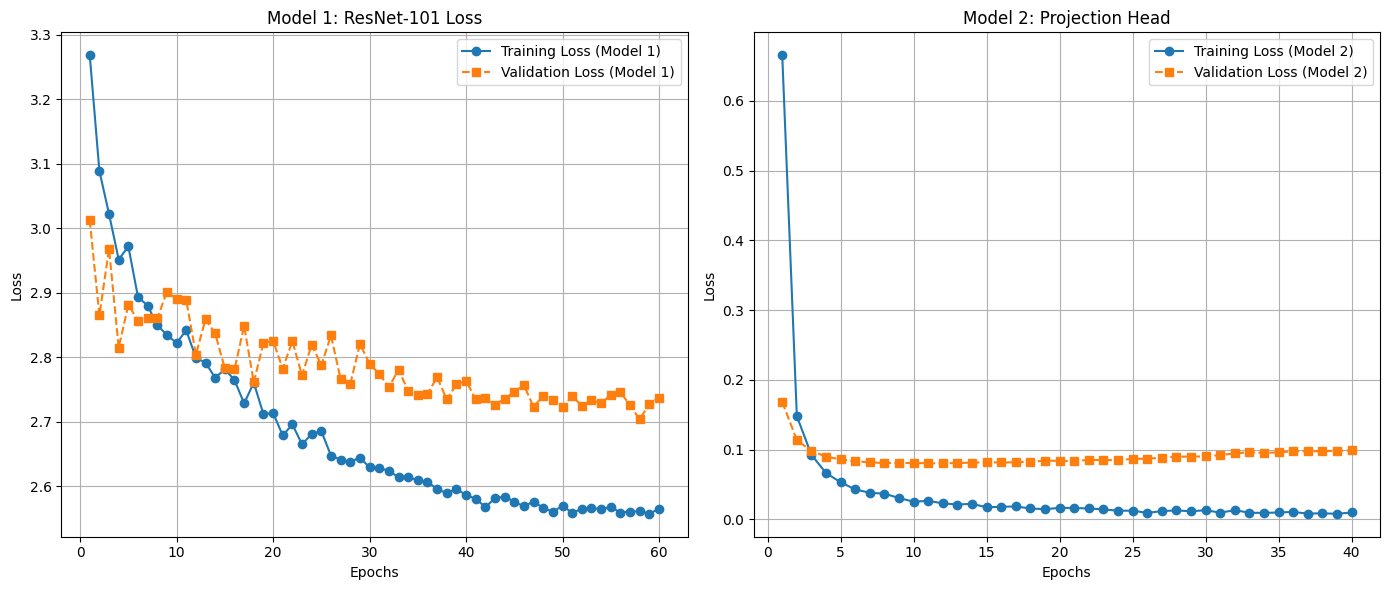

In [15]:
import pickle
import matplotlib.pyplot as plt

with open('/kaggle/working/Pickles/train_losses_encoder_resnet101.pkl', 'rb') as f:
    train_losses_model1 = pickle.load(f)

with open('/kaggle/working/Pickles/valid_losses_encoder_resnet101.pkl', 'rb') as f:
    valid_losses_model1 = pickle.load(f)

with open('/kaggle/working/Pickles/train_losses_projection_head.pkl', 'rb') as f:
    train_losses_model2 = pickle.load(f)

with open('/kaggle/working/Pickles/valid_losses_projection_head.pkl', 'rb') as f:
    valid_losses_model2 = pickle.load(f)


def prepare_data(train_losses, valid_losses):
    if isinstance(train_losses, list) and isinstance(valid_losses, list):
        epochs = list(range(1, len(train_losses) + 1))
        train_loss_values = train_losses
        valid_loss_values = valid_losses
    elif isinstance(train_losses, dict) and isinstance(valid_losses, dict):
        common_epochs = sorted(set(train_losses.keys()) & set(valid_losses.keys()))
        if not common_epochs:
            raise ValueError("No common epochs found in train_losses and valid_losses.")
        train_loss_values = [train_losses[epoch] for epoch in common_epochs]
        valid_loss_values = [valid_losses[epoch] for epoch in common_epochs]
        epochs = common_epochs
    else:
        raise TypeError("train_losses and valid_losses must both be lists or both be dictionaries.")
    

    try:
        train_loss_values = [float(loss) for loss in train_loss_values]
        valid_loss_values = [float(loss) for loss in valid_loss_values]
    except ValueError as e:
        raise ValueError("Non-numeric loss values found.") from e
    
    return epochs, train_loss_values, valid_loss_values


epochs1, train_loss_values1, valid_loss_values1 = prepare_data(train_losses_model1, valid_losses_model1)
epochs2, train_loss_values2, valid_loss_values2 = prepare_data(train_losses_model2, valid_losses_model2)

# Plot the data
plt.figure(figsize=(14, 6))

# Plot for Model 1
plt.subplot(1, 2, 1)
plt.plot(epochs1, train_loss_values1, label='Training Loss (Model 1)', marker='o', linestyle='-')
plt.plot(epochs1, valid_loss_values1, label='Validation Loss (Model 1)', marker='s', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model 1: ResNet-101 Loss')
plt.legend()
plt.grid(True)

# Plot for Model 2
plt.subplot(1, 2, 2)
plt.plot(epochs2, train_loss_values2, label='Training Loss (Model 2)', marker='o', linestyle='-')
plt.plot(epochs2, valid_loss_values2, label='Validation Loss (Model 2)', marker='s', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model 2: Projection Head')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()
